In [2]:
import numpy as np
import pandas as pd
import torch 
import scipy
import time

import sys
sys.path.append('../../')  # Add the parent directory to the Python path

from torch_NN.nn import ResNN_pricing

device = torch.device('cpu')
tensor_dtype = torch.float64

# Set the derivatives dynamic model's parameter's nums here !
Paranums = 11

hyperparas = {'input_dim':Paranums,'hidden_dim':64,'hidden_nums':10,'output_dim':88,'block_layer_nums':3}

model = ResNN_pricing(hyperparas=hyperparas).to(device=device,dtype=tensor_dtype)

model_state = torch.load('../../Data/YU/rpiecewiseBergomi.pth')

model.load_state_dict(model_state)

model.eval()


model.to(device=device,dtype=tensor_dtype)

ResNN_pricing(
  (linear_stock): Sequential(
    (0): Sequential(
      (0): Linear(in_features=11, out_features=64, bias=True)
      (1): ReLU()
    )
    (1): ResNetBlock(
      (layers): ModuleList(
        (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
      )
      (layernorms): ModuleList(
        (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (2): ResNetBlock(
      (layers): ModuleList(
        (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
      )
      (layernorms): ModuleList(
        (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (3): ResNetBlock(
      (layers): ModuleList(
        (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
      )
      (layernorms): ModuleList(
        (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (4): ResNetBlock(
      (layers): ModuleList(
        (0-1): 2 x Linear(in_features=64, out_features=64, b

In [3]:
import gzip
f = gzip.GzipFile(r'../../Data/TrainrBergomiTermStructure.txt.gz', "r")
dat=np.load(f)
xx=dat[:,:Paranums]
yy=dat[:,Paranums:]

strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x_train, x_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)
scale_x = StandardScaler()
scale_y=  StandardScaler()

def xtransform(x_train, x_test):
    return [scale_x.fit_transform(x_train),scale_x.transform(x_test)]

def xinversetransform(x):
    return scale_x.inverse_transform(x)

def ytransform(y_train,y_test):
    return [scale_y.fit_transform(y_train),scale_y.transform(y_test)]

def yinversetransform(y):
    return scale_y.inverse_transform(y)

# Upper and lower bounds used in the training set
ub=np.array([0.16,0.16,0.16,0.16,0.16,0.16,0.16,0.16,4,0,0.5])
lb=np.array([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.5,-1,0.025])

def myscale(x):
    return (x - (ub+lb)*0.5)*2/(ub-lb)
def myinverse(x):
    return x*(ub-lb)*0.5+(ub+lb)*0.5

x_train_transform = myscale(x_train)
x_test_transform = myscale(x_test)
[y_train_transform,y_test_transform] = ytransform(y_train,y_test)


train_data = (torch.from_numpy(x_train_transform).to(device=device),torch.from_numpy(y_train_transform).to(device=device))
test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))

In [4]:
def CostFunc(x,sample_ind):
    return np.sum(np.power((model(torch.from_numpy(x)).detach().numpy()
                            -y_test_transform[sample_ind]),2))


import time
import scipy
Approx=[]
Timing=[]
solutions=np.zeros([1,Paranums])
times=0
init=np.zeros(Paranums)
for i in range(x_test_transform.shape[0]):
    disp=str(i+1)+f"/{x_test_transform.shape[0]}"
    print (disp,end="\r")
    #L-BFGS-B
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='L-BFGS-B',tol=1E-10,options={"maxiter":10000})
    end= time.time()
    solutions[0,:]=myinverse(I.x)
    times=end-start
    
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))
    

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

print(f"Average Calibration time is: {np.mean(Timing,axis=0):.3f}s" )

Approx = np.array(Approx).reshape(-1,11)
Approx.shape

Average Calibration time is: 0.571s


(12000, 11)

In [14]:
LMParameters=Approx
np.savetxt(f"../../Data/YU/NNParametersrbergomipiecewise_cali_LBFGSB.txt",LMParameters)
LMParameters = np.loadtxt(f"../../Data/YU/NNParametersrbergomipiecewise_cali_LBFGSB.txt")
LMParameters.shape

(12000, 11)

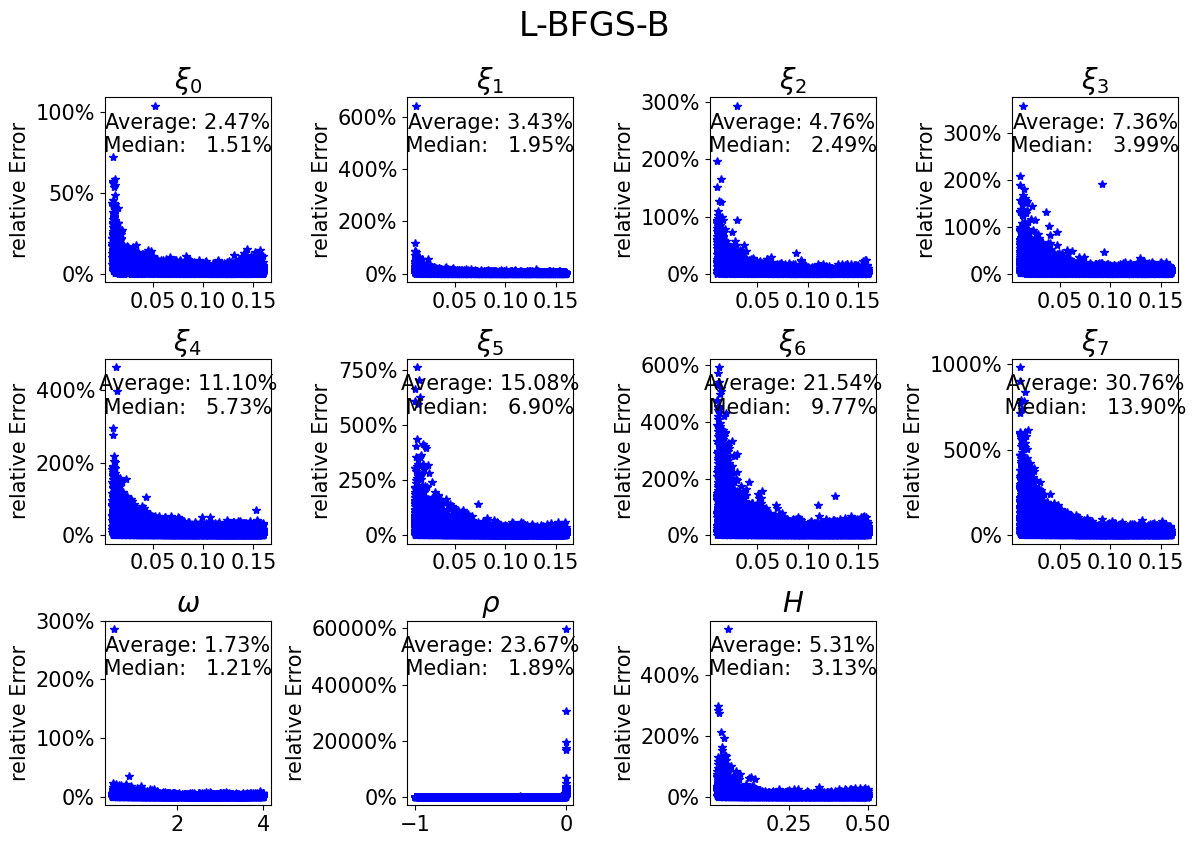

In [16]:
titles=["$\\xi_0$","$\\xi_1$","$\\xi_2$","$\\xi_3$","$\\xi_4$",
        "$\\xi_5$","$\\xi_6$","$\\xi_7$","$\\omega$","$\\rho$","$H$"]
average=np.zeros([Paranums,12000])
fig=plt.figure(figsize=(12,8))
for u in range(Paranums):
    ax=plt.subplot(3,4,u+1)
    x=x_test[:,u]
    plt.plot(x,100*np.abs(LMParameters[:,u]-x)/np.abs(x),'b*')
    average[u,:]=np.abs(LMParameters[:,u]-x)/np.abs(x)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()
plt.suptitle(f"L-BFGS-B", fontsize=24, y=1.05)
plt.savefig('rBergomiParameterRelativeErrors_piecewise.png', dpi=300)
plt.show();
